# 1 Data Generation

Identical code we used for Lab 5

In [ ]:
import string
import random
from random import randint
import cv2
import numpy as np
import os
from PIL import Image, ImageFont, ImageDraw

In [ ]:
# Run this command only once:

# makes the output folder /content/pictures/
!mkdir pictures

In [ ]:
# Run this command only once

# Downloads the license plate template to /content/blank_plate.png
!gdown --id 1Q_FsX2z6DaDCLM91qGZzwvctaW9bN60v

Downloading...
From: https://drive.google.com/uc?id=1Q_FsX2z6DaDCLM91qGZzwvctaW9bN60v
To: /content/blank_plate.png
100% 144k/144k [00:00<00:00, 1.99MB/s]


In [ ]:
path = "/content/"

NUMBER_OF_PLATES = 4

test_plates = []
for i in range(0, NUMBER_OF_PLATES):

    # Pick two random letters
    plate_alpha = ""
    for _ in range(0, 2):
        plate_alpha += (random.choice(string.ascii_uppercase))

    # Pick two random numbers
    num = randint(0, 99)
    plate_num = "{:02d}".format(num)

    # Write plate to image
    blank_plate = cv2.imread(path+'blank_plate.png')

    # Convert into a PIL image (this is so we can use the monospaced fonts)
    blank_plate_pil = Image.fromarray(blank_plate)

    # Get a drawing context
    draw = ImageDraw.Draw(blank_plate_pil)
    monospace = ImageFont.truetype(font="/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf", 
                                   size=165)
    draw.text(xy=(48, 75),
              text=plate_alpha + " " + plate_num, 
              fill=(255,0,0), font=monospace)

    # Convert back to OpenCV image and save
    blank_plate = np.array(blank_plate_pil)
    test_plates.append(blank_plate)

    # Write license plate to file
    cv2.imwrite(os.path.join(path + "pictures/", 
                             "plate_{}{}.png".format(plate_alpha, plate_num)),
                             blank_plate)

# 2 Data Augmentation

We will use keras ImageDataGenerator for augmenting our image dataset for training a neural network.

In [ ]:
%tensorflow_version 1.14.0

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.14.0`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt

In [ ]:
#Convert the test_plates list to a numpy array.
test_plates = np.array(test_plates)

In [ ]:
# We will use this custom filter function in addition to the standard 
# augmentation techniques. You will want to modify this function to fit your 
# needs.

def my_filter(image):
  '''
  @brief filter that introduces rescaling artifacts and changes the color 
         channel order to match plt.imshow() format
  @param image: input image to be modified
  @retval image with 
  '''
  resize_factor = 0.1
  initial_shape = image.shape
  #Need to reverse the order of width and height because PIL format is reversed 
  #from cv2 format.
  initial_shape = tuple(reversed(initial_shape[0:2])) + (initial_shape[2],)

  #resize height and width
  small_shape = tuple((np.array(initial_shape[0:2]) * resize_factor).astype(int))

  #scale down and scale back up to introduce rescaling artifacts
  res = cv2.resize(image, dsize=small_shape, interpolation=cv2.INTER_LINEAR)
  res = cv2.resize(res, dsize=initial_shape[0:2], interpolation=cv2.INTER_NEAREST)

  #rearrange the color channels so imshow displays the appropriate colors
  res = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)
  return res

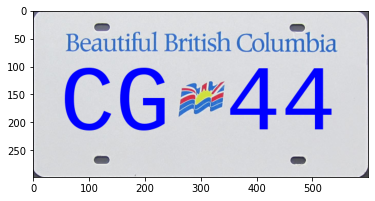

In [ ]:
# An example of a perfect image
plt.imshow(cv2.cvtColor(test_plates[0], cv2.COLOR_BGR2RGB))

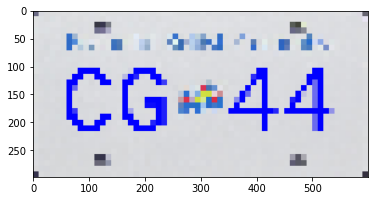

In [ ]:
# An example of the  filtered image. It has the same size as the input image but 
# introduces rescaling artifacts similar to what we would observe when using 
# the ROS environment.
plt.imshow(my_filter(test_plates[0]))

In [ ]:
#Create a data generating object - check out 
datagen = ImageDataGenerator(fill_mode='constant',
                             preprocessing_function=my_filter,
                             zoom_range=0.1,
                             width_shift_range=0.1, height_shift_range=0.1,
                             brightness_range=[0.2,1.3],
                             rotation_range=5)

aug_iter = datagen.flow(test_plates, batch_size=1)

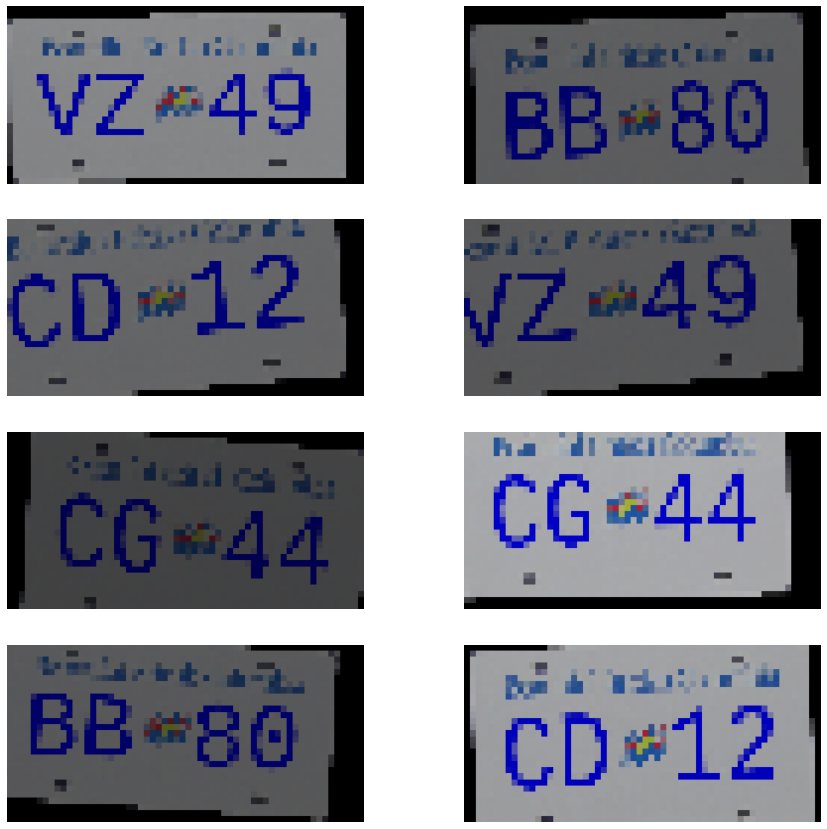

In [ ]:
# Create our plotting figure
NUM_COLS = 2
NUM_ROWS = 4
fig, ax = plt.subplots(nrows=NUM_ROWS, ncols=NUM_COLS, figsize=(15,15))

# Generate a batch of images. The iterator will "return" randoml modified 
# image every time we call it.
for i in range(NUM_COLS):
  for j in range (NUM_ROWS):
    # convert to unsigned integers
    image = next(aug_iter)[0].astype('uint8')

    # plot image
    ax[j,i].imshow(image)
    ax[j,i].axis('off')

#3 Binarizing and displaying images

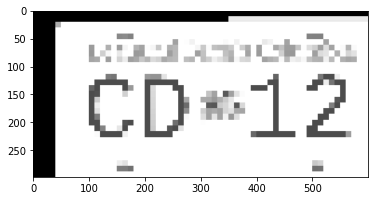

In [ ]:
test_gray = cv2.cvtColor(next(aug_iter)[0].astype('uint8'), cv2.COLOR_BGR2GRAY)
plt.imshow(test_gray, cmap='gray')

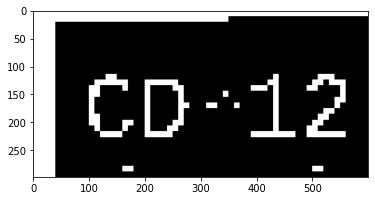

In [ ]:
THRESHOLD = 124
FILL_VALUE = 255
_, test_binary = cv2.threshold(test_gray, THRESHOLD, FILL_VALUE, cv2.THRESH_BINARY_INV)
plt.imshow(test_binary, cmap='gray')